In [1]:
# jupyter notebook   # 또는 jupyter lab 해서 커널에서 실행하면 됨
# -----------------------------------------------------------
# [1] 기본 세팅
# -----------------------------------------------------------
import os, glob, re, h5py
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

Data_dir = "/home/swpants05/Desktop/2025_FastMri/Data"   # ← 본인 경로로 수정


In [2]:
# -----------------------------------------------------------
# [2] 유틸 함수
# -----------------------------------------------------------
def load_mask(h5_path:str) -> np.ndarray:
    """h5 파일에서 1-D mask를 로드 (float32 → bool)."""
    with h5py.File(h5_path, 'r') as f:
        m = f['mask'][()]          # shape: (width,)
    return m.astype(bool)

def plot_masks(mask4:np.ndarray, mask8:np.ndarray, title:str="mask comparison"):
    """두 마스크를 한 눈에 비교."""
    x = np.arange(len(mask4))
    plt.figure(figsize=(8,3))
    plt.plot(x, mask4, label='acc4', lw=2)
    plt.plot(x, mask8, label='acc8', lw=2, alpha=.7)
    plt.fill_between(x, mask4, alpha=.15)
    plt.fill_between(x, mask8, alpha=.15)
    plt.title(title); plt.xlabel('k-space readout'); plt.ylabel('sampled (1/0)')
    plt.legend(); plt.ylim(-.1, 1.1); plt.show()

def accel_factor(mask:np.ndarray) -> float:
    return round(len(mask) / mask.sum(), 2)

def load_image_label(h5_path:str) -> np.ndarray:
    with h5py.File(h5_path,'r') as f:
        return f['image_label'][()]   # shape: (slices,H,W)


In [3]:
# -----------------------------------------------------------
# [3] 파일 매칭 (acc4 <-> acc8)
# -----------------------------------------------------------
def make_pairs(scan_type:str="brain") -> list[Tuple[str,str]]:
    """scan_type='brain' or 'knee'"""
    p4 = sorted(glob.glob(os.path.join(Data_dir, "train/image", f"{scan_type}_acc4_*.h5")))
    p8 = sorted(glob.glob(os.path.join(Data_dir, "train/image", f"{scan_type}_acc8_*.h5")))
    
    # 같은 인덱스 넘버를 가지는 쌍 만들기
    pat = re.compile(rf"{scan_type}_acc[48]_(\d+).h5")
    dict4 = {pat.search(os.path.basename(p)).group(1):p for p in p4}
    dict8 = {pat.search(os.path.basename(p)).group(1):p for p in p8}
    
    common_keys = sorted(set(dict4) & set(dict8), key=int)
    return [(dict4[k], dict8[k]) for k in common_keys]

brain_pairs = make_pairs("brain")
knee_pairs  = make_pairs("knee")
print(f"매칭된 brain 쌍 {len(brain_pairs)}개 / knee 쌍 {len(knee_pairs)}개 발견")


매칭된 brain 쌍 85개 / knee 쌍 85개 발견


----
acc4: brain_acc4_1.h5
acc8: brain_acc8_1.h5
  - mask  acc4 accel ≈3.22x,  acc8 accel ≈5.14x


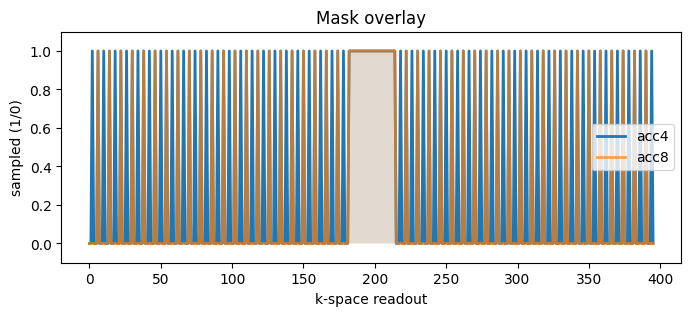

  - 마스크 XOR 합계(≠ 부분 개수): 46 / 396
  - label 동일? True


In [4]:
# -----------------------------------------------------------
# [4] 첫 번째 쌍 시각화: 마스크/레이블 비교
# -----------------------------------------------------------
def inspect_pair(img4_path:str, img8_path:str):
    print("----")
    print("acc4:", os.path.basename(img4_path))
    print("acc8:", os.path.basename(img8_path))
    
    # 4,8 마스크 로드 & 비교
    mas4 = load_mask(img4_path.replace("/image/","/kspace/").replace("_acc4_","_acc4_"))
    mas8 = load_mask(img8_path.replace("/image/","/kspace/").replace("_acc8_","_acc8_"))
    
    print(f"  - mask  acc4 accel ≈{accel_factor(mas4)}x,  acc8 accel ≈{accel_factor(mas8)}x")
    plot_masks(mas4, mas8, "Mask overlay")
    print(f"  - 마스크 XOR 합계(≠ 부분 개수): {np.count_nonzero(mas4 ^ mas8)} / {len(mas4)}")
    
    # Label 이미지 동일성 확인 (첫 슬라이스만 비교)
    lab4 = load_image_label(img4_path)
    lab8 = load_image_label(img8_path)
    diff = np.abs(lab4.astype(np.float32) - lab8.astype(np.float32))
    same = np.allclose(lab4, lab8, atol=1e-3)
    print(f"  - label 동일? {same}")
    
    if not same:
        # 눈으로도 보기
        sl = 0
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1); plt.imshow(lab4[sl], cmap='gray'); plt.title("label acc4"); plt.axis('off')
        plt.subplot(1,3,2); plt.imshow(lab8[sl], cmap='gray'); plt.title("label acc8"); plt.axis('off')
        plt.subplot(1,3,3); plt.imshow(diff[sl], cmap='hot');   plt.title("|diff|");    plt.axis('off')
        plt.suptitle("First slice label comparison"); plt.show()

# 샘플 확인
inspect_pair(*brain_pairs[0])


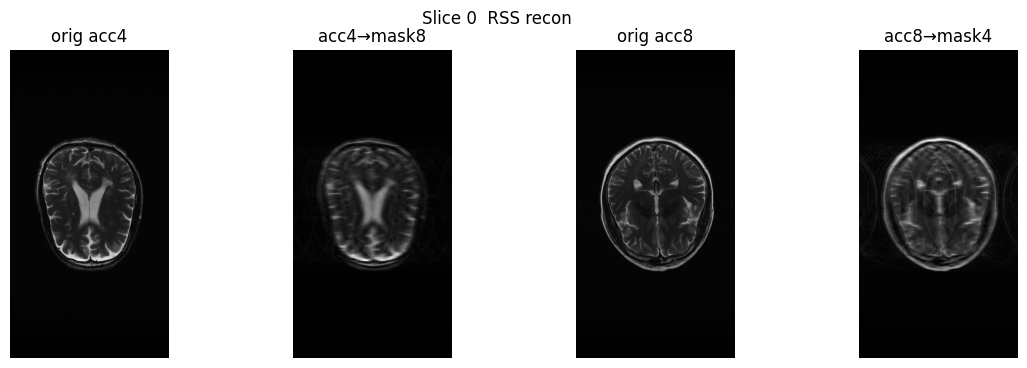

In [5]:
# -----------------------------------------------------------
# [5] (선택) 마스크 스와핑 예시
# -----------------------------------------------------------
def rss(img:np.ndarray, axis=0) -> np.ndarray:
    """root-sum-square across 'coil' axis"""
    return np.sqrt((img**2).sum(axis=axis))

def quick_ifft2(kspace:np.ndarray) -> np.ndarray:
    """간단 2D IFFT → 이미지 (복소)."""
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(kspace, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def swap_and_show(kspace4_file:str, kspace8_file:str, slice_idx:int=0, coil_idx:int=0):
    """acc4 k-space에 acc8 마스크를 적용하고 반대도 해보기."""
    with h5py.File(kspace4_file,'r') as f4, h5py.File(kspace8_file,'r') as f8:
        k4, m4 = f4['kspace'][slice_idx], f4['mask'][()]
        k8, m8 = f8['kspace'][slice_idx], f8['mask'][()]
    
    # 스와핑
    k4_to_8 = k4 * m8[None,None,:]      # acc4 데이터에 acc8 마스크
    k8_to_4 = k8 * m4[None,None,:]      # acc8 데이터에 acc4 마스크
    
    # 간단 RSS reconstruction
    img_k4    = rss(np.abs(quick_ifft2(k4)))
    img_k4to8 = rss(np.abs(quick_ifft2(k4_to_8)))
    img_k8    = rss(np.abs(quick_ifft2(k8)))
    img_k8to4 = rss(np.abs(quick_ifft2(k8_to_4)))
    
    # 시각화
    fig,ax = plt.subplots(1,4,figsize=(14,4))
    for a,i,t in zip(ax,
                     [img_k4, img_k4to8, img_k8, img_k8to4],
                     ['orig acc4','acc4→mask8','orig acc8','acc8→mask4']):
        a.imshow(i,cmap='gray'); a.set_title(t); a.axis('off')
    plt.suptitle(f"Slice {slice_idx}  RSS recon"); plt.show()

# 예시 실행
swap_and_show(
    brain_pairs[0][0].replace("/image/","/kspace/"),   # 같은 인덱스의 kspace 경로
    brain_pairs[0][1].replace("/image/","/kspace/"),
    slice_idx=0
)


In [6]:
# -----------------------------------------------------------
# [6] 여러 쌍에 대해 통계적으로 label 동일 여부 체크
# -----------------------------------------------------------
def quick_stat(pairs):
    mismatch = 0
    for p4,p8 in pairs:
        lab4 = load_image_label(p4)[0]   # 첫 슬라이스만 샘플링
        lab8 = load_image_label(p8)[0]
        if not np.allclose(lab4, lab8, atol=1e-3):
            mismatch += 1
    print(f"총 {len(pairs)}쌍 중 label 다른 경우 {mismatch}쌍")

quick_stat(brain_pairs)
quick_stat(knee_pairs)


총 85쌍 중 label 다른 경우 0쌍
총 85쌍 중 label 다른 경우 0쌍
